# Optimisation de la composition d'un portefeuille de stocks


<p align="center">Réalisé par Maria Aboulaala</p>

### Introduction:


Ce projet se décompose en différentes sections, chacune reposant sur les précédentes. Dans la première section, l'accent sera mis sur la collecte des données nécessaires à l'analyse. Ces données sont relativement simples, il s'agit des prix de clôture d'un petit portefeuille d'actions.

Après avoir traité la collecte des données, la prochaine étape consistera à préparer ces données pour le calcul de plusieurs métriques cruciales en vue d'obtenir des résultats optimaux dans notre portefeuille. Parmi les métriques à calculer, on retrouvera les rendements attendus, la volatilité attendue, et le ratio de Sharpe. Une fois ces métriques définies, nous entrerons dans le processus de création d'une simulation qui générera aléatoirement des résultats que nous pourrons exploiter pour déterminer les meilleurs résultats pour une grande variété de portefeuilles.

Les résultats de cette simulation seront utilisés pour créer des graphiques à l'aide de `matplotlib`, et nous utiliserons la bibliothèque `scipy` pour exécuter un algorithme d'optimisation afin de déterminer les pondérations optimales pour notre simulation.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
from pprint import pprint
from sklearn.preprocessing import StandardScaler

Je choisi ['AAPL', 'MSFT', 'SQ'] comme actifs pour mon portefeuille.

In [20]:
symbols = ['AAPL', 'MSFT', 'SQ']
number_of_symbols = len(symbols)
price_data_frame: pd.DataFrame = pd.read_csv('stock_data.csv')
print(price_data_frame.head())


         date   close    volume    open      high     low symbol
0  2020-07-23  122.93  11010220  127.74  129.8494  121.32     SQ
1  2020-07-22  129.18   8437494  127.49  131.7100  127.06     SQ
2  2020-07-21  126.99  10787520  129.95  130.8000  125.07     SQ
3  2020-07-20  128.39  12423990  121.26  129.4600  120.53     SQ
4  2020-07-17  120.73   6968161  120.98  122.3800  118.59     SQ


Les données sont assez proches de ce dont nous avons besoin, mais elles nécessitent encore un peu de mise en forme avant de passer aux étapes suivantes. Nous pouvons utiliser la méthode `pivot` pour réorganiser les données afin d'obtenir une seule colonne pour chaque symbole, où chaque colonne contient le prix de clôture. En ayant les données de cette manière, nous pouvons ensuite calculer les rendements pour chaque jour.

In [21]:
price_data_frame = price_data_frame[['date', 'symbol', 'close']]
price_data_frame = price_data_frame.pivot(
    index='date',
    columns='symbol',
    values='close'
)
print(price_data_frame.head())

symbol        AAPL    MSFT     SQ
date                             
2020-01-24  318.31  165.04  71.14
2020-01-27  308.95  162.28  71.05
2020-01-28  317.69  165.46  74.80
2020-01-29  324.34  168.04  76.16
2020-01-30  323.87  172.78  76.10


Pour générer les rendements de notre portfefeuille, nous devons prendre un certain **risque**, mais idéalement, nous devrions être à l'aise avec ce risque car nous sommes compensés sous forme de rendements qui augmentent notre investissement.

Cependant, la plupart des investisseurs ne sont pas à l'aise avec des niveaux élevés de risque, donc notre objectif est de trouver le meilleur ratio risque/rendement. Idéalement, nous prenons le maximum de risque avec lequel nous nous sentons à l'aise et cherchons à maximiser ces rendements. Cela nous amène naturellement à une question importante : "Comment mesurons-nous le risque ?".  Dans notre cas, nous utiliserons le `Sharpe Ratio`. Le Sharpe Ratio est utilisé pour calculer le rendement ajusté en fonction du risque et est la norme de l'industrie pour de tels calculs. Le Sharpe Ratio nous permet de quantifier la relation entre le rendement moyen gagné en excès du taux sans risque par unité de volatilité ou de risque total.

Mathématiquement, nous définissons le Sharpe Ratio comme suit :

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Où :

$
\begin{align}
\ R_p & = \text{Rendement du Portefeuille} \\
\ R_f & = \text{Taux Sans Risque} \\
\ \sigma_p & = \text{Écart Type du Rendement Excédentaire du Portefeuille} \\
\end{align}
$

Pour calculer les rendements attendus, nous utilisons la formule suivante :

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Où :

$
\begin{align}
\ r_{i} & = \text{Rendement de la Sécurité i} \\
\ w_{i} & = \text{Poids de la Sécurité i} \\
\end{align}
$

Pour calculer l'écart type du portefeuille, nous utilisons la formule suivante :

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Où :

$
\begin{align}
\ \sigma_{i} & = \text{Écart Type des Rendements de la Sécurité i} \\
\ w_{i} & = \text{Poids de la Sécurité i} \\
\ p_{i,j} & = \text{Coefficient de Corrélation entre les rendements de l'actif i et de l'actif j} \\
\end{align}
$

In [23]:
# Calcule du Log rendement.
log_return = np.log(1 + price_data_frame.pct_change())

# Generer des poids aleatoires.
random_weights = np.array(np.random.random(number_of_symbols))

# Poids de chaque actifs pour que la somme soit eguale a 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calcule du rendement attendus, (252 jours de trading en moyenne par année).
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calcule de la volatilité attendus.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calcule du Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol


weights_df = pd.DataFrame(data={
' poids aleatoires': random_weights,
' poids aleatoires ajusté': rebalance_weights
})
print('')
print('='*80)
print(' poids de chaque actifs:')
print('-'*80)
print(weights_df)
print('-'*80)


metrics_df = pd.DataFrame(data={
    'rendement attendus': exp_ret,
    'volatilité attendus': exp_vol,
    'Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('Metrique de portefeuille:')
print('-'*80)
print(metrics_df)
print('-'*80)


 poids de chaque actifs:
--------------------------------------------------------------------------------
    poids aleatoires   poids aleatoires ajusté
0           0.843391                  0.654073
1           0.400123                  0.310306
2           0.045930                  0.035620
--------------------------------------------------------------------------------

Metrique de portefeuille:
--------------------------------------------------------------------------------
   rendement attendus  volatilité attendus  Sharpe Ratio
0            0.370694             0.537652      0.689469
--------------------------------------------------------------------------------


# Optimisation de Portefeuille : Simulation de Monte Carlo

Nous disposons maintenant d'une méthode pour évaluer la répartition de notre portefeuille. Cela implique de calculer les rendements attendus, la volatilité attendue, puis à partir de là, nous utilisons le Ratio de Sharpe pour quantifier la qualité de la répartition de notre portefeuille du point de vue du risque. La grande question ici est la suivante : "Si nous savons que nous voulons obtenir un ratio de Sharpe plus élevé, quelle est la répartition de portefeuille nécessaire pour y parvenir ?"

Il y a deux façons d'aborder cette question. Premièrement, nous pourrions tester différentes répartitions aléatoires et voir lesquelles produisent le Ratio de Sharpe le plus élevé. Deuxièmement, nous pourrions utiliser une optimisation mathématique définie par certaines contraintes pour parvenir à la répartition optimale. Dans ce qui suit, nous allons utiliser la méthode "essayer plusieurs répartitions aléatoires" qui est la une simulation de Monte Carlo. 

**Les simulations de Monte Carlo sont utilisées pour modéliser la probabilité de différents résultats dans un processus qui ne peut pas être facilement prédit en raison de l'intervention de variables aléatoires. Il s'agit d'une technique utilisée pour comprendre l'impact du risque et de l'incertitude dans les modèles de prévision.**

Nous allons alors exécuter le processus que nous avons décrit ci-dessus à plusieurs reprises et stocker les résultats de chaque exécution. Une fois que nous aurons terminé chaque exécution, nous trouverons les répartitions qui produisent le Ratio de Sharpe le plus élevé et la volatilité la plus faible.

In [24]:
# Initialisation des composants pour exécuter une simulation de Monte Carlo.

# Nous allons effectuer 5000 itérations.
num_of_portfolios = 5000

# Préparer un tableau pour stocker les pondérations au fur et à mesure de leur génération, soit 5000 itérations pour chacun de nos 4 symboles.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Préparer un tableau pour stocker les rendements au fur et à mesure de leur génération, soit 5000 valeurs de rendement possibles.
ret_arr = np.zeros(num_of_portfolios)

# Préparer un tableau pour stocker les volatilités au fur et à mesure de leur génération, soit 5000 valeurs de volatilité possibles.
vol_arr = np.zeros(num_of_portfolios)

# Préparer un tableau pour stocker les ratios de Sharpe au fur et à mesure de leur génération, soit 5000 ratios de Sharpe possibles.
sharpe_arr = np.zeros(num_of_portfolios)

# Début des simulations.
for ind in range(num_of_portfolios):

    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    all_weights[ind, :] = weights

    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

simulations_df = pd.DataFrame(data=simulations_data).T


simulations_df.columns = [
    'Rendements',
    'Volatilité',
    'Ratio de Sharpe',
    'Pondérations du Portefeuille'
]

simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('RÉSULTAT DES SIMULATIONS:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


RÉSULTAT DES SIMULATIONS:
--------------------------------------------------------------------------------
   Rendements  Volatilité  Ratio de Sharpe  \
0    0.580506    0.606698         0.956830   
1    0.611189    0.613361         0.996459   
2    0.405071    0.543874         0.744789   
3    0.601751    0.609269         0.987662   
4    0.660715    0.637163         1.036964   

                        Pondérations du Portefeuille  
0  [0.5636865905048443, 0.10992830382683583, 0.32...  
1  [0.19338353291853455, 0.4904559112574578, 0.31...  
2  [0.5210234506882461, 0.41318154957624176, 0.06...  
3  [0.21070168061326064, 0.4842595772904483, 0.30...  
4  [0.21790339871082737, 0.3905276549897461, 0.39...  
--------------------------------------------------------------------------------


# Obtenir les Principaux Indicateurs

Maintenant que nous avons effectué notre simulation, examinons quelques indicateurs intéressants. Le premier, est le `max_sharpe_ratio`, c'est le Ratio de Sharpe où le rendement excédentaire du portefeuille est le plus élevé compte tenu du niveau de risque que nous prenons. En d'autres termes, ces portefeuilles sont les "meilleurs" car ils offrent les rendements ajustés en fonction du risque les plus élevés. Le prochain indicateur est le `min_volatility`, ce sont les pondérations pour lesquelles la volatilité globale du portefeuille est la plus basse. En d'autres termes, si vous souhaitez prendre le moins de risque possible, ce sont les pondérations que vous souhaiteriez avoir.


In [26]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Ratio de Sharpe'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatilité'].idxmin()]

print('')
print('='*80)
print('Maximum Ratio de Sharpe:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('Minimum Volatilité:')
print('-'*80)
print(min_volatility)
print('-'*80)


Maximum Ratio de Sharpe:
--------------------------------------------------------------------------------
Rendements                                                               1.091693
Volatilité                                                               0.908427
Ratio de Sharpe                                                           1.20174
Pondérations du Portefeuille    [0.0032738102558762237, 0.012171052869200647, ...
Name: 3439, dtype: object
--------------------------------------------------------------------------------

Minimum Volatilité:
--------------------------------------------------------------------------------
Rendements                                                               0.341429
Volatilité                                                               0.533056
Ratio de Sharpe                                                          0.640513
Pondérations du Portefeuille    [0.7079155567539342, 0.2909303799429097, 0.001...
Name: 1194, dtype: object
--

# Tracé des Données :

A se stade Il est utile de voir les résultats de notre simulation sous forme de graphique. Nous utiliserons `matplotlib` pour créer un graphique de dispersion qui montre la relation entre la volatilité globale de notre portefeuille et les rendements attendus. Idéalement, ce que nous devrions voir, c'est qu'à mesure que nous prenons plus de risque, nous devrions obtenir des rendements ajustés en fonction du risque plus élevés. On peut dire l'inverse pour la volatilité, moins de volatilité signifie des rendements attendus plus faibles.


C:\Users\maria\AppData\Local\Temp\ipykernel_26080\1541782405.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\maria\AppData\Local\Temp\ipykernel_26080\1541782405.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\maria\AppData\Local\Temp\ipykernel_26080\1541782405.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_volatility[1],
C:\Users\maria\AppData\Local\Temp

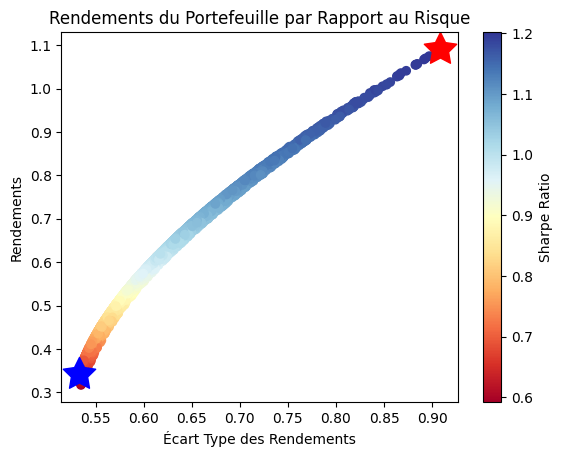

In [30]:
plt.scatter(
    y=simulations_df['Rendements'],
    x=simulations_df['Volatilité'],
    c=simulations_df['Ratio de Sharpe'],
    cmap='RdYlBu'
)

plt.title('Rendements du Portefeuille par Rapport au Risque')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Écart Type des Rendements')
plt.ylabel('Rendements')

# Max Sharpe Ratio = `Etoile rouge`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Min Volatilité = `Etoile bleu`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

plt.show()

# Optimisation

La première methode de determination des ponderations optimal consistait à utiliser la simulation de Monte Carlo qui essaierait des milliers de valeurs aléatoires et trouverait les meilleures valeurs. L'inconvénient de l'utilisation de la simulation de Monte Carlo est que ce n'est pas la manière la plus efficace de trouver les valeurs optimales. Au lieu de cela, nous pouvons utiliser des techniques mathématiques pour arriver facilement aux valeurs optimales.

Pour aider à exécuter cette nouvelle méthode d'optimisation, nous devrons définir quelques fonctions supplémentaires que nous utiliserons dans notre méthode. La première fonction est la fonction `get_metrics()`, qui renverra les métriques pour un ensemble de pondérations données. La deuxième fonction est la fonction `neg_sharpe`, qui est utilisée comme fonction de minimisation. La fonction de minimisation est utilisée pour trouver les valeurs qui donnent le ratio de Sharpe le plus bas. Dans la fonction d'optimisation de Scipy, il n'y a pas de fonction de "maximisation", donc il faut passer quelque chose qui doit être minimisé.

La troisième fonction est la fonction `check_sum`, qui est utilisée comme une contrainte. Ce qu'elle fera, c'est s'assurer que les pondérations qui sont transmises respectent la contrainte selon laquelle nous devons avoir une allocation de portefeuille égale à 100 %, ni plus ni moins.

In [32]:
def get_metrics(weights: list) -> np.array:

    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )
    sr = ret / vol 

    return np.array([ret, vol, sr])

# --------------------------------------------------

def grab_negative_sharpe(weights: list) -> np.array:

    return get_metrics(weights)[2] - 1

# --------------------------------------------------

def grab_volatility(weights: list) -> np.array:

    return get_metrics(weights)[1]

# --------------------------------------------------

def check_sum(weights: list) -> float:

    return np.sum(weights) - 1

Avec nos fonctions désormais définies, exécutons l'optimisation en utilisant le module `scipy.optimize`. Ce module contient une fonction appelée `minimize` que nous pouvons utiliser pour obtenir nos valeurs optimales. Cependant, nous devons effectuer quelques étapes avant de l'exécuter. Tout d'abord, nous devons définir des bornes, ce qui indique à la fonction `minimize` que chacune de nos positions ne peut représenter qu'entre 0 % et 100 % de l'allocation. Deuxièmement, nous devons définir la contrainte qui sera une fonction (`fun`) qui garantit que nous avons une allocation de portefeuille égale à 100 % (nous utilisons tout le "capital" disponible). Troisièmement, nous devons définir notre estimation initiale des pondérations. L'estimation initiale peut être n'importe quoi, mais dans ce cas, commençons par simplifier et choisissons un portefeuille également réparti. Dans ce cas, nous avons 4 symboles, de sorte que chaque symbole représentera 25 % du portefeuille.

Une fois que nous avons défini ces étapes, nous pouvons exécuter l'optimisation en passant les arguments définis et en définissant la méthode comme `SLSQP`, ce qui signifie "Sequential Least Squares Programming" (programmation séquentielle des moindres carrés). Une fois que nous avons exécuté la méthode `minimize`, nous pouvons obtenir les résultats.

Le premier résultat est le résultat de notre opération de minimisation. À l'intérieur des résultats, vous verrez le ratio de Sharpe optimisé défini par la valeur `fun`. Nous pouvons ensuite prendre les `pondérations optimisées` définies par les valeurs `optimized_sharpe.x`, et les utiliser pour obtenir les différentes métriques de notre portefeuille.

In [33]:
bounds = tuple((0, 1) for symbol in range(number_of_symbols))
constraints = ({'type': 'eq', 'fun': check_sum})
init_guess = number_of_symbols * [1 / number_of_symbols]

optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimiser
    init_guess, # commence avec ses valeurs.
    method='SLSQP',
    bounds=bounds, # ne depasse pas ces bornes.
    constraints=constraints
)

print('')
print('='*80)
print('RATIO DE SHARPE OPTIMISE:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


RATIO DE SHARPE OPTIMISE:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.41952441797981443
       x: [ 1.000e+00  0.000e+00  2.359e-15]
     nit: 4
     jac: [-7.451e-09  2.132e-01  1.381e+00]
    nfev: 16
    njev: 4
--------------------------------------------------------------------------------


In [34]:
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

print('')
print('='*80)
print('PENDERATION OPTIMISE:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('METRIQUES OPTIMISER:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


PENDERATION OPTIMISE:
--------------------------------------------------------------------------------
[1.00000000e+00 0.00000000e+00 2.35922393e-15]
--------------------------------------------------------------------------------

METRIQUES OPTIMISER:
--------------------------------------------------------------------------------
[0.31086729 0.53553897 0.58047558]
--------------------------------------------------------------------------------


In [35]:
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

constraints = ({'type': 'eq', 'fun': check_sum})

init_guess = number_of_symbols * [1 / number_of_symbols]

optimized_volatility = sci_opt.minimize(
    grab_volatility, 
    init_guess, 
    method='SLSQP',
    bounds=bounds, 
    constraints=constraints 
)

print('')
print('='*80)
print('VOLATILITE OPTIMISE::')
print('-'*80)
print(optimized_volatility)
print('-'*80)


VOLATILITE OPTIMISE::
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5328609543036874
       x: [ 7.485e-01  2.515e-01  4.337e-19]
     nit: 6
     jac: [ 5.329e-01  5.328e-01  6.439e-01]
    nfev: 24
    njev: 6
--------------------------------------------------------------------------------


In [36]:

optimized_metrics = get_metrics(weights=optimized_volatility.x)

print('')
print('='*80)
print('PONDERATION OPTIMISE:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)

print('')
print('='*80)
print('METRIQUES OPTIMISER:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


PONDERATION OPTIMISE:
--------------------------------------------------------------------------------
[7.48507668e-01 2.51492332e-01 4.33680869e-19]
--------------------------------------------------------------------------------

METRIQUES OPTIMISER:
--------------------------------------------------------------------------------
[0.33649631 0.53286095 0.6314899 ]
--------------------------------------------------------------------------------
